<a href="https://colab.research.google.com/github/katjasit0815/Data-Science-academic-projects/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

from sklearn.base import clone
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from dask.distributed import Client
import joblib
from tqdm import tqdm

from sklearn.metrics import precision_recall_curve, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import classification_report, average_precision_score, make_scorer, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
files.upload()

!pip install --upgrade --quiet kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip -q creditcardfraud

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.10GB/s]


In [ ]:
print(os.listdir())
pd.set_option('display.max_columns', None)
df = pd.read_csv('creditcard.csv')
df.head()

['.config', 'kaggle.json', 'creditcardfraud.zip', 'creditcard.csv', 'sample_data']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

In [ ]:
print('Размер датасета:', df.shape,'\n')
print(df.info())

Размер датасета: (284807, 31) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 n

Распределение классов:
Class
0    284315
1       492
Name: count, dtype: int64

Процент мошенников: 0.173%


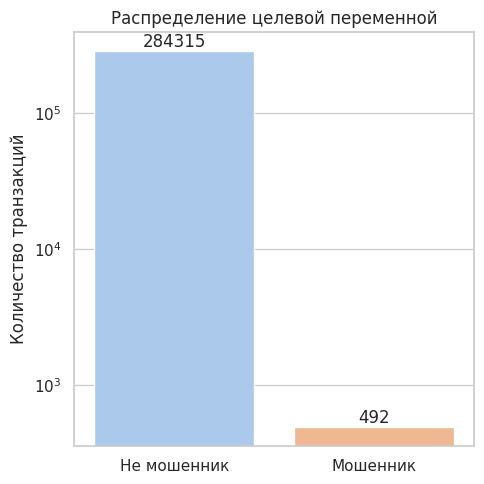

In [ ]:
sns.set(style="whitegrid")

class_counts = df["Class"].value_counts()
print("Распределение классов:")
print(class_counts)
print(f"\nПроцент мошенников: {100 * class_counts[1] / len(df):.3f}%")

plt.figure(figsize=(5, 5))
ax = sns.countplot(
    x="Class",
    data=df,
    palette="pastel",

)
ax.set_yscale('log')
for p in ax.patches:
    cnt = int(p.get_height())
    ax.annotate(f"{cnt}",
                (p.get_x() + p.get_width()/2, max(cnt, 1)),
                ha="center", va="bottom")
ax.set_title("Распределение целевой переменной")
ax.set_xlabel("")
ax.set_xticklabels(["Не мошенник", "Мошенник"])
ax.set_ylabel("Количество транзакций")
plt.tight_layout()
plt.show()

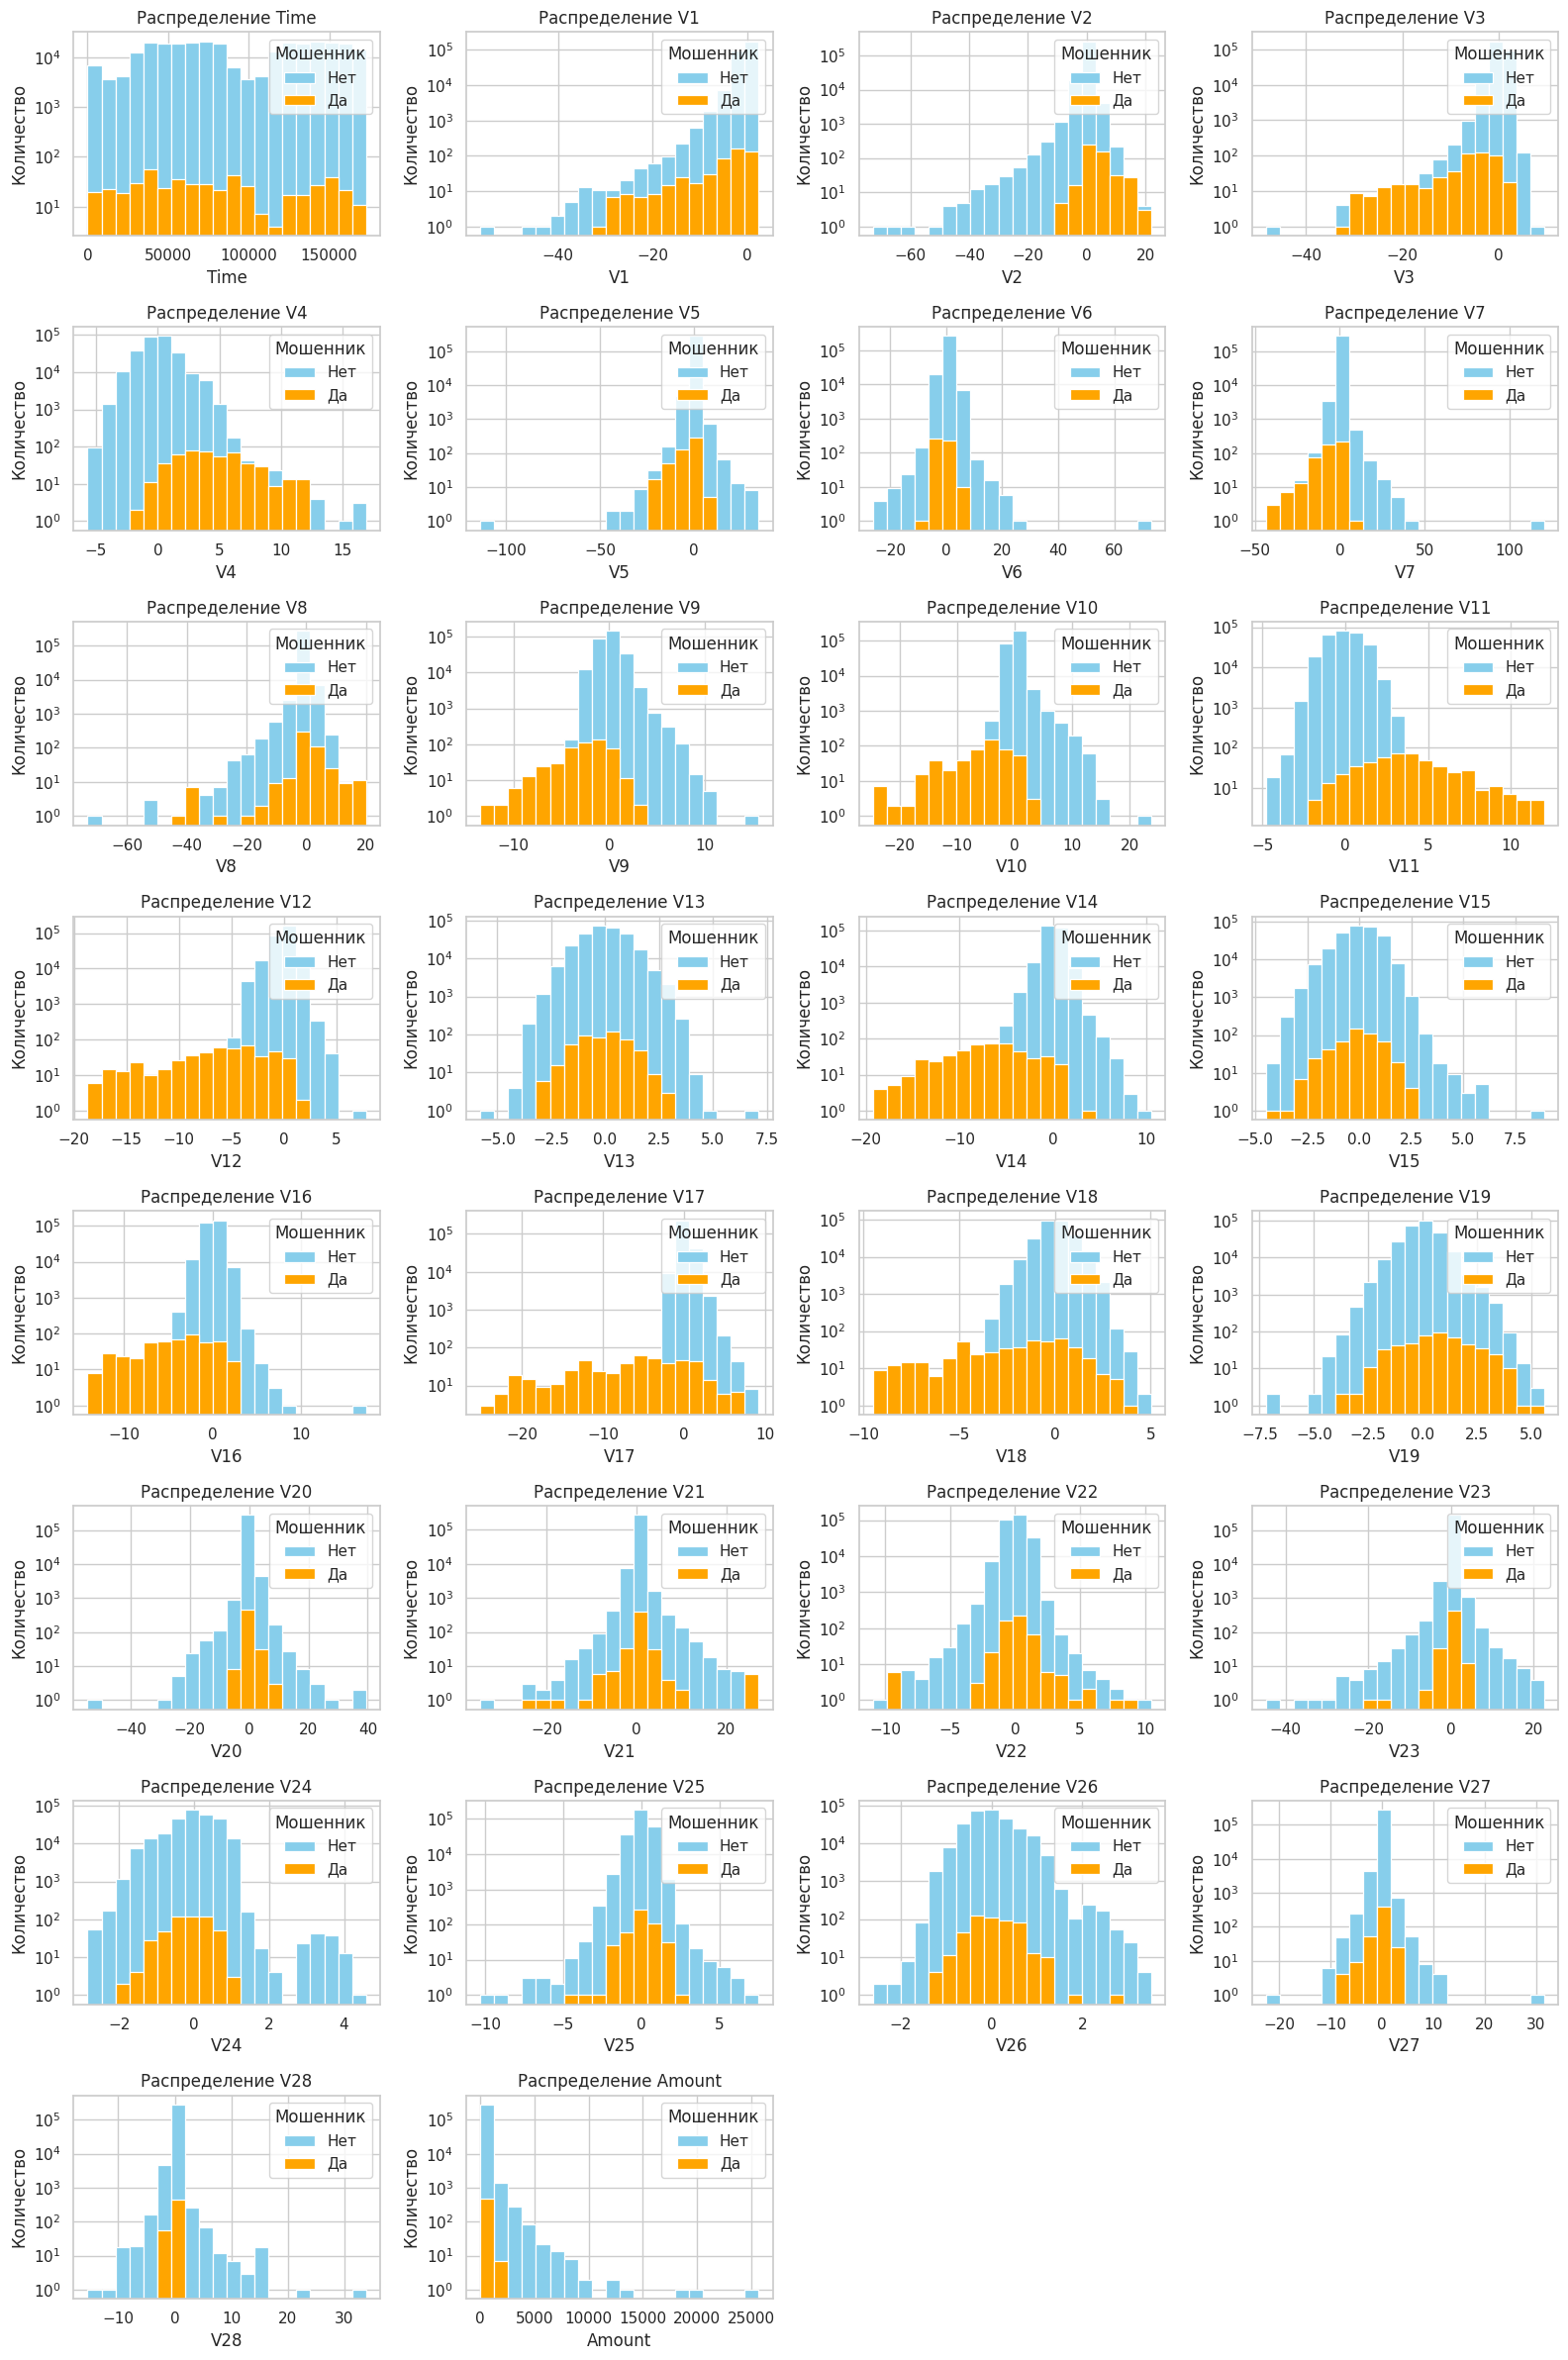

In [ ]:
features = df.columns.drop(['Class'])
n = len(features)
ncols = 4
nrows =ceil(n / ncols)

fig, axes = plt.subplots(
    nrows   = nrows,
    ncols   = ncols,
    figsize = (4 * ncols, 3 * nrows),
    sharey  = False
)
axes = axes.flatten()

for ax, feature in zip(axes, features):
    sns.histplot(
        data    = df,
        x       = feature,
        hue     = 'Class',
        hue_order = [1, 0],
        bins    = 20,
        palette={0:'skyblue', 1:'orange'},
        alpha     = 1.0,
        ax      = ax
    )
    ax.set_title(f'Распределение {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество')
    ax.set_yscale('log')
    ax.legend(loc='upper right', title='Мошенник',labels=['Нет', 'Да'])

for ax in axes[len(features):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Отметим, что на графиках компонент V9, V10, V12, V14, V16-V18 обнаружено, что сильно отрицательные значения признака говорят о том, что транзакция была проведена мошенником.
А, в свою очередь, преобладание сильно положительных значений очень вероятно для действий мошенников на графиках компонент V2, V4 и V11.

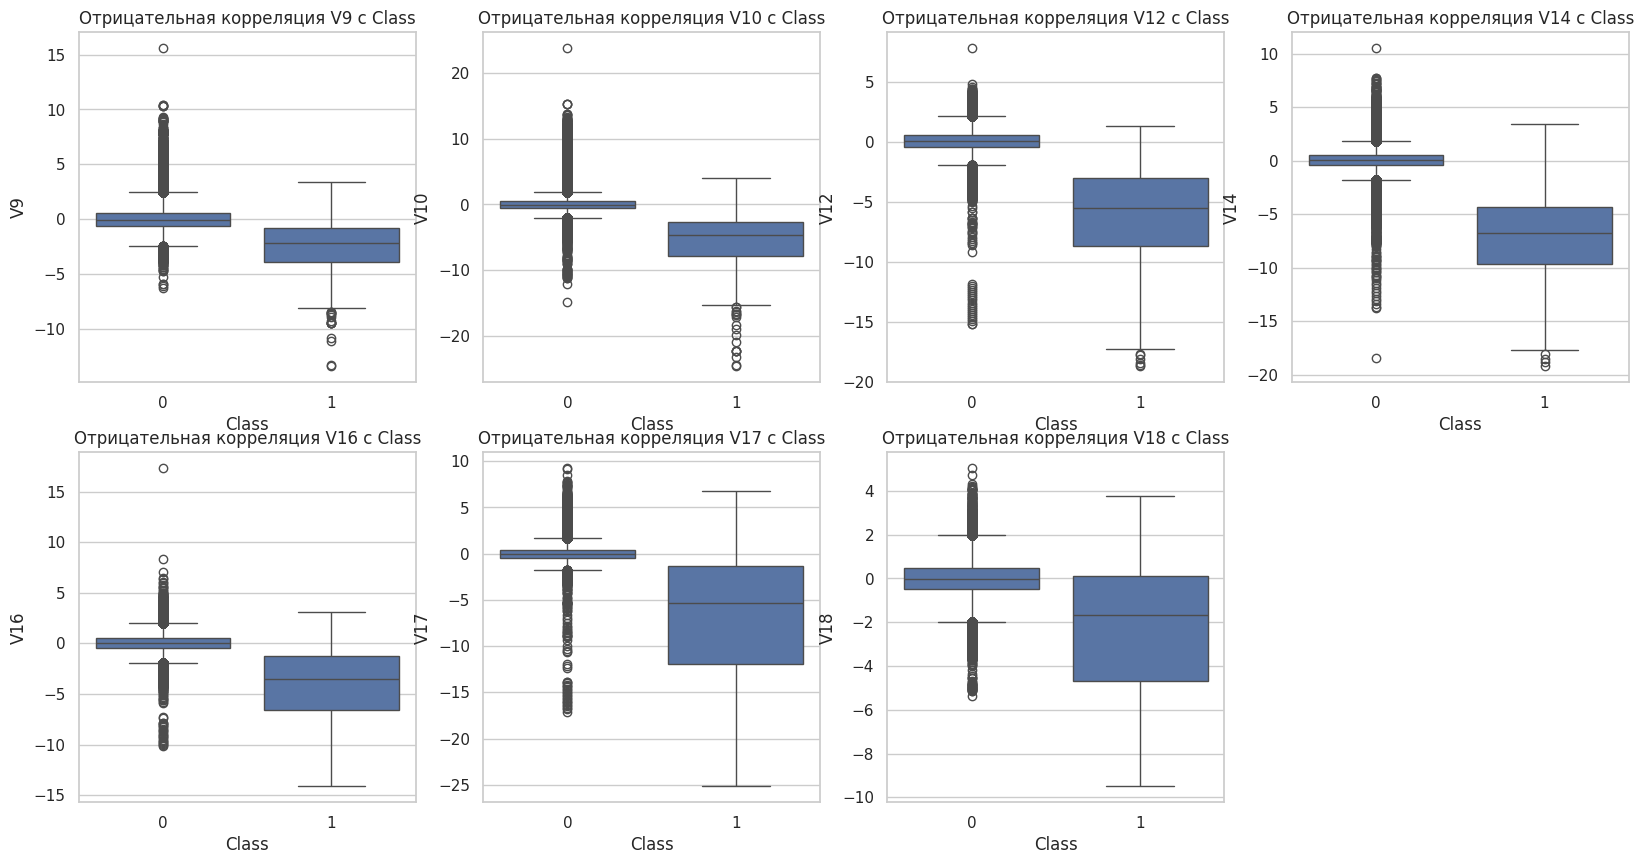

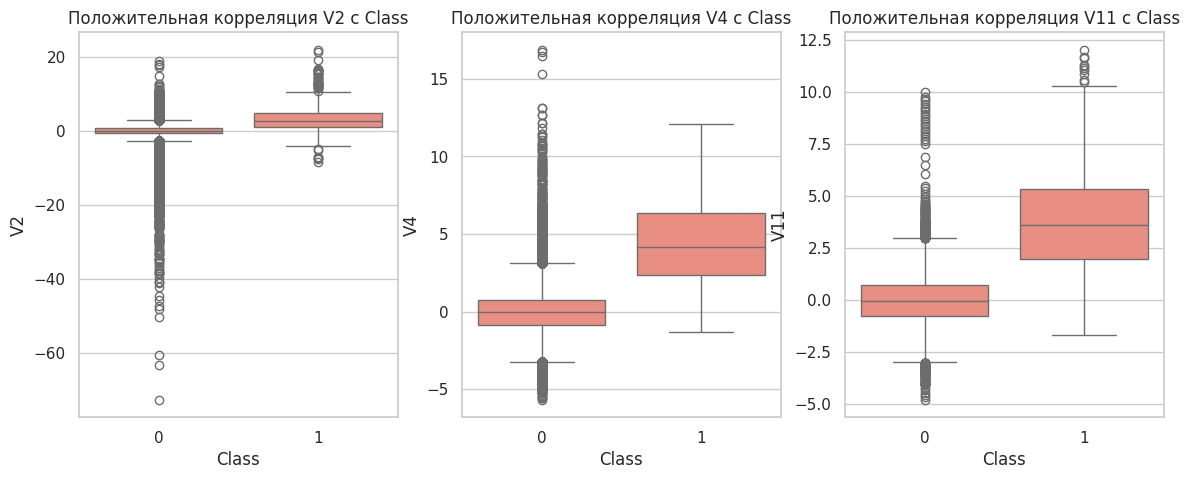

In [ ]:
negative_corr = ['V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V18']
positive_corr = ['V2', 'V4', 'V11']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharey=False)

for idx, feature in enumerate(negative_corr):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]

    sns.boxplot(x="Class", y=feature, data=df, ax=ax)
    ax.set_title(f'Отрицательная корреляция {feature} с Class')
fig.delaxes(axes[1, 3])

fig, axes = plt.subplots(ncols=3, figsize=(14, 5), sharey=False)

for idx, feature in enumerate(positive_corr):
    ax = axes[idx]
    sns.boxplot(x="Class", y=feature, data=df, ax=ax, palette=['salmon'])
    ax.set_title(f'Положительная корреляция {feature} с Class')
plt.show()

По boxplot у целевого класса видим выбросы у компонент V9, V10, V12, V14 с отрицательной корреляцией и V2 и V11 с положительной корреляцией. Избавимся от них, посчитав интерквартильный размах как разность между 1-м и 3-м квартилями распределения. При обучение сравним, как изменятся метрики моделей.

In [ ]:
features = ['V9', 'V10', 'V12', 'V14', 'V2', 'V11']

df_iqr = df.copy()

for feat in features:

    fraud_vals = df_iqr.loc[df_iqr['Class'] == 1, feat]
    Q1 = fraud_vals.quantile(0.25)
    Q3 = fraud_vals.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = (
        (df_iqr['Class'] == 0) |
        ((df_iqr['Class'] == 1) &
         df_iqr[feat].between(lower_bound, upper_bound))
    )

    df_iqr = df_iqr[mask]

print(f"Было строк: {len(df)}, после фильтрации (только мошенников): {len(df_iqr)}")

Было строк: 284807, после фильтрации (только мошенников): 284700


Найдем характерые для мошенников часы проведения транзакций с помощью анализа признака Time: сделаем столбцы Day и Hour, чтобы понять, как распределяется частота мошеннических транзакций за два дня по часам.

In [ ]:
df['Day'] = (df['Time'] // (24 * 3600)) + 1
df['Hour'] = (df['Time'] % (24 * 3600)) / 3600

df_iqr['Day'] = (df_iqr['Time'] // (24 * 3600)) + 1
df_iqr['Hour'] = (df_iqr['Time'] % (24 * 3600)) / 3600

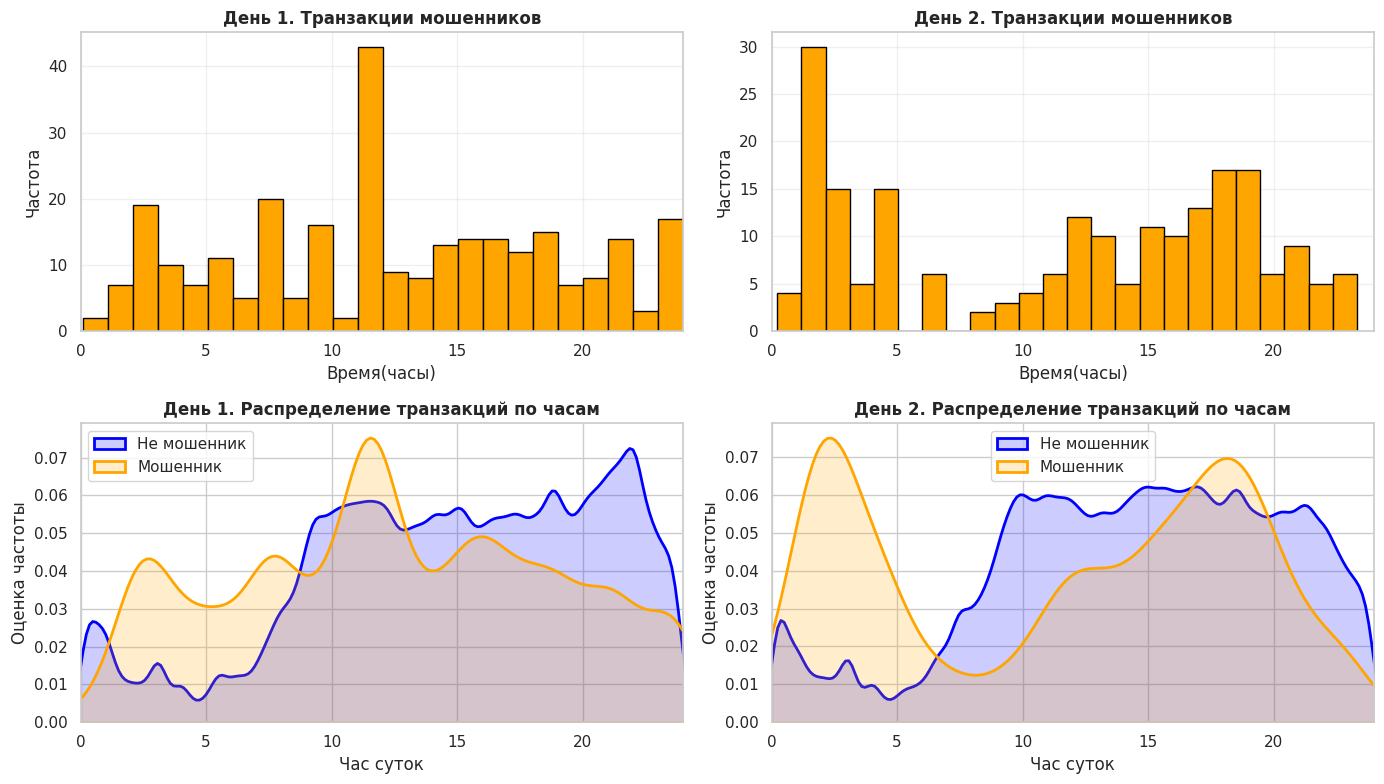

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

day1_fraud = df[(df["Class"] == 1) & (df['Day']==1)]["Time"] / 3600
day2_fraud = (df[(df["Class"] == 1) & (df['Day']==2)]["Time"] / 3600) - 24

days_list = [day1_fraud, day2_fraud]
for i, data in enumerate(days_list):
    axes[0, i].hist(data, bins=24, color='orange',edgecolor="black")

    axes[0, i].set_xlabel("Время(часы)")
    axes[0, i].set_ylabel("Частота")
    axes[0, i].set_title(f"День {i+1}. Транзакции мошенников", fontsize=12, fontweight="bold")
    axes[0, i].set_xlim(0, 24)
    axes[0, i].grid(True, alpha=0.3)

day1_legit = df[(df["Class"] == 0) & (df['Day']==1)]["Time"] / 3600
day2_legit = (df[(df["Class"] == 0) & (df['Day']==2)]["Time"] / 3600) - 24

for i in range(2):
    sns.kdeplot(
        data=df[df.Day==i+1],
        x='Hour',
        hue='Class',
        hue_order=[1, 0],
        ax = axes[1, i],
        common_norm=False,
        fill=True,
        bw_adjust=0.5,
        palette={0:'blue',1:'orange'},
        alpha=0.2,
        linewidth=2
    )
    axes[1, i].set_title(f'День {i+1}. Распределение транзакций по часам', fontsize=12, fontweight="bold")
    axes[1, i].set_xlabel('Час суток')
    axes[1, i].set_ylabel('Оценка частоты')
    axes[1, i].set_xlim(0, 24)
    axes[1, i].legend(['Не мошенник','Мошенник'])
plt.tight_layout()
plt.show()

По графикам распределений за оба дня наблюдаем, что в период с 1 до 5 часов утра мошенники совершают транзакции в ~2 раза чаще, чем обычные клиенты банков.

## Обучение моделей

In [ ]:
df = df.drop(columns=['Time'])
df_iqr = df_iqr.drop(columns=['Time'])

X = df.drop('Class', axis=1)
y = df['Class']

X_iqr = df_iqr.drop('Class', axis=1)
y_iqr = df_iqr['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_iqr, y_iqr, test_size=0.2, random_state=42)

In [ ]:
print("До:", Counter(y_train), Counter(y_train_iqr))

smote = SMOTE(sampling_strategy={1: 2000}, random_state=42)

rus = RandomUnderSampler(sampling_strategy={0: 4000, 1: 2000}, random_state=42)

def balance(X, y):
    X_under, y_under = smote.fit_resample(X, y)
    X_over, y_over = rus.fit_resample(X_under, y_under)
    return X_over, y_over

X_train_bal, y_train_bal = balance(X_train, y_train)
X_train_iqr_bal, y_train_iqr_bal = balance(X_train_iqr, y_train_iqr)

print("После orig-train:",   Counter(y_train_bal))
print("После iqr-train:",    Counter(y_train_iqr_bal))

До: Counter({0: 227451, 1: 394}) Counter({0: 227467, 1: 293})
После orig-train: Counter({0: 4000, 1: 2000})
После iqr-train: Counter({0: 4000, 1: 2000})


In [ ]:
client = Client(processes=True, n_workers=2, threads_per_worker=1)

client.wait_for_workers(n_workers=2)
joblib.parallel_backend('dask')

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = [
    {'clf': [LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')],
      'clf__C': [1, 5, 8, 10, 12, 15]},
    {'clf': [RandomForestClassifier(random_state=42, class_weight='balanced')],
      'clf__n_estimators': [50, 100, 150],
      'clf__min_samples_leaf':[3, 5, 10],
      'clf__max_depth': [2, 3, 5]},
    {'clf': [KNeighborsClassifier()],
      'clf__n_neighbors': list(range(2,10,1))}
]

best_overall_score = -1
best_overall_params = None

for sub_grid in param_grid:
    print(f"\nЗапускаем GridSearch для пакета: {sub_grid.keys()}")

    grid = GridSearchCV(
        pipeline,
        param_grid=sub_grid,
        cv=3,
        scoring='average_precision',
        n_jobs=1,
        verbose=3
    )

    grid.fit(X_train_bal, y_train_bal)
    results = pd.DataFrame(grid.cv_results_)
    print("  Лучшие параметры для этого пакета:", grid.best_params_)
    print("  Лучший AUPRC (cv) для этого пакета:", grid.best_score_)

    if grid.best_score_ > best_overall_score:
        best_overall_score  = grid.best_score_
        best_overall_params = grid.best_params_

print("Лучшие параметры среди всех пакетов:", best_overall_params)
print("Лучший AUPRC (cv) среди всех пакетов:", best_overall_score)

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33665
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:45843/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45295'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38693'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:34647 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:34647
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:40230
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:33661 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33661
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:40242
INFO:distributed.scheduler:Receive client connection: Client-95d00656-bc89-11f0-81aa-0242ac1c000c
INFO:distributed.core:Starting establis


Запускаем GridSearch для пакета: dict_keys(['clf', 'clf__C'])
Fitting 3 folds for each of 6 candidates, totalling 18 fits


INFO:distributed.scheduler:Receive client connection: Client-worker-9a7715d2-bc89-11f0-8484-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:40290
INFO:distributed.scheduler:Receive client connection: Client-worker-9a789c63-bc89-11f0-8487-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:40300


  Лучшие параметры для этого пакета: {'clf': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), 'clf__C': 8}
  Лучший AUPRC (cv) для этого пакета: 0.9879269164603829

Запускаем GridSearch для пакета: dict_keys(['clf', 'clf__n_estimators', 'clf__min_samples_leaf', 'clf__max_depth'])
Fitting 3 folds for each of 27 candidates, totalling 81 fits
  Лучшие параметры для этого пакета: {'clf': RandomForestClassifier(class_weight='balanced', random_state=42), 'clf__max_depth': 5, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 100}
  Лучший AUPRC (cv) для этого пакета: 0.9868751167098867

Запускаем GridSearch для пакета: dict_keys(['clf', 'clf__n_neighbors'])
Fitting 3 folds for each of 8 candidates, totalling 24 fits
  Лучшие параметры для этого пакета: {'clf': KNeighborsClassifier(), 'clf__n_neighbors': 9}
  Лучший AUPRC (cv) для этого пакета: 0.9813888357627455
Лучшие параметры среди всех пакетов: {'clf': LogisticRegression(class_weight='balanced', max_iter=1000, r

In [ ]:
joblib.parallel_backend('loky')

Лучшая модель - лог. регрессия, поэтому дальше обучать ее.

In [ ]:
best_model = grid.best_estimator_

model_orig = clone(best_model)
model_orig.fit(X_train, y_train)

model_iqr = clone(best_model)
model_iqr.fit(X_train_iqr, y_train_iqr)

def eval_and_print(name, model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    print("AUPRC =", average_precision_score(y_test, y_proba))

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

eval_and_print("Обычный train", model_orig, X_test, y_test)
eval_and_print("IQR train", model_iqr, X_test, y_test)

AUPRC = 0.6591615132863577
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.53      0.67        98

    accuracy                           1.00     56962
   macro avg       0.96      0.77      0.84     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC = 0.7343398494306373
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.47      0.62        98

    accuracy                           1.00     56962
   macro avg       0.95      0.73      0.81     56962
weighted avg       1.00      1.00      1.00     56962



Метрика AUPRC выше на 0.07 после исключения шумов, поэтому при обучении будем использовать train_iqr. Также по classification_report можем сказать, что порог бинаризации 0,5 является не оптимальным. Далее переберем сэмплеры:

In [ ]:
pipeline = ImbPipeline([
    ('sampler', SMOTE()),
    ('clf', LogisticRegression(C=8,max_iter=1_000, random_state=42))
])

param_grid = {
    'sampler': [
        RandomUnderSampler(random_state=42),
        RandomUnderSampler(sampling_strategy={0: 2000, 1: 2000}, random_state=42),
        RandomUnderSampler(sampling_strategy={0: 4000, 1: 2000}, random_state=42),
        SMOTE(random_state=42),
        SMOTE(sampling_strategy={0: 2000, 1: 2000}, random_state=42),
        SMOTE(sampling_strategy={0: 4000, 1: 2000}, random_state=42)
    ],
}

scoring = {'auprc': make_scorer(average_precision_score)}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=scoring,
    refit='auprc',
    n_jobs=1,
    verbose=2
)

grid.fit(X_train_iqr, y_train_iqr)

print("Лучший сэмплер", grid.best_params_)
print("Лучшее CV AUPRC:", grid.best_score_)


best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]
print("Тест AUPRC:", average_precision_score(y_test, y_proba))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ........sampler=RandomUnderSampler(random_state=42); total time=   8.0s
[CV] END ........sampler=RandomUnderSampler(random_state=42); total time=   6.2s
[CV] END ........sampler=RandomUnderSampler(random_state=42); total time=   1.4s
[CV] END sampler=RandomUnderSampler(random_state=42, sampling_strategy={0: 2000, 1: 2000}); total time=   0.1s
[CV] END sampler=RandomUnderSampler(random_state=42, sampling_strategy={0: 2000, 1: 2000}); total time=   0.0s
[CV] END sampler=RandomUnderSampler(random_state=42, sampling_strategy={0: 2000, 1: 2000}); total time=   0.0s
[CV] END sampler=RandomUnderSampler(random_state=42, sampling_strategy={0: 4000, 1: 2000}); total time=   0.0s
[CV] END sampler=RandomUnderSampler(random_state=42, sampling_strategy={0: 4000, 1: 2000}); total time=   0.0s
[CV] END sampler=RandomUnderSampler(random_state=42, sampling_strategy={0: 4000, 1: 2000}); total time=   0.0s
[CV] END .....................s

Лучшим сэмплером оказался SMOTE. Теперь подребем оптимальный порог. Для начала посмотрим кривые precision и recall в зависимости от порога:

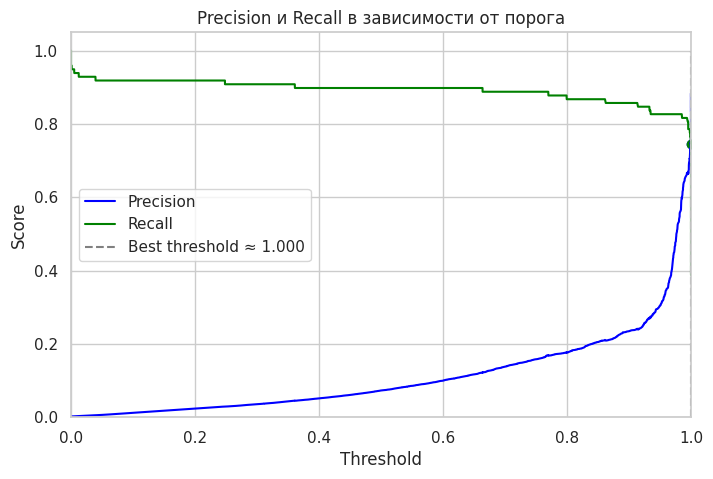

In [ ]:
y_proba = best_model.predict_proba(X_test)[:, 1]
y_true  = y_test

precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

precision = precision[:-1]
recall    = recall[:-1]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision, label='Precision', color='blue')
plt.plot(thresholds, recall,    label='Recall',    color='green')

idx = np.argmin(np.abs(precision - recall))
best_t, best_p, best_r= thresholds[idx], precision[idx], recall[idx]

plt.scatter([best_t], [best_p], color='blue')
plt.scatter([best_t], [best_r], color='green')

plt.title('Precision и Recall в зависимости от порога')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.ylim(0.0, 1.05)
plt.xlim(0.0, 1.0)
plt.legend(loc='best')
plt.grid(True)
plt.show()

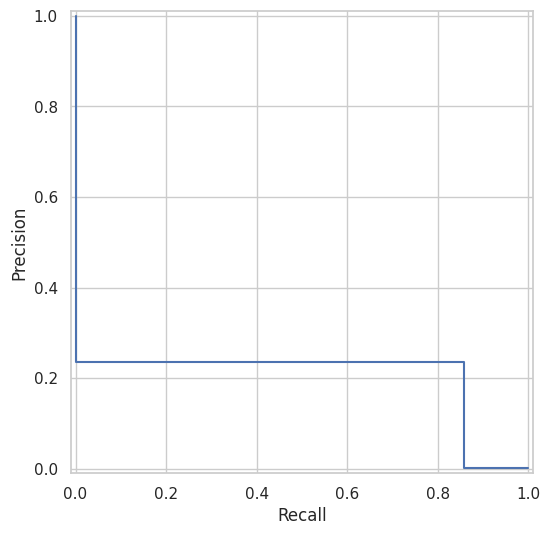

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

prec, recall, thresholds = precision_recall_curve(
    y_test,
    y_pred,
    pos_label=1
)

disp = PrecisionRecallDisplay(precision=prec, recall=recall)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
plt.show()

In [ ]:
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\n=== Classification report, порог = {threshold:.1f} ===")
    print(classification_report(y_true, y_pred, zero_division=0))


=== Classification report, порог = 0.5 ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.90      0.13        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962


=== Classification report, порог = 0.6 ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.90      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962


=== Classification report, порог = 0.7 ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.89      0.24        98

    accuracy                           0.99     56

Я считаю, что значение recall остается высоким при всех порогах, но f1_score значительно выше при 0.9 и порог стоит выбрать 0.9.

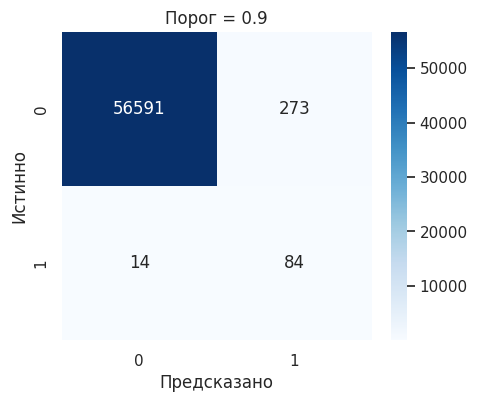

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.title(f"Порог = {threshold}")
plt.show()